In [19]:
import sys
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import os
import math

from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, f1_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import statsmodels.api as sm

In [33]:
#Data on Microsoft
Msft_final = pd.read_csv('MicrosoftFinalData.csv', delimiter=',')
Msft_final.dataframeName = 'MicrosoftFinalData.csv'
Msft_news = pd.read_csv('MicrosoftNewsStock.csv', delimiter=',')
Msft_news.dataframeName = 'MicrosoftNewsStock.csv'

#Data on S&P500
SNP500_data = pd.read_csv('^GSPC.csv', delimiter=',')
SNP500_data.dataframeName = '^GSPC.csv'

#Data on DJI
DJI_data = pd.read_csv('^DJI.csv', delimiter=',')
DJI_data.dataframeName = '^DJI.csv'
DJI_news = pd.read_csv('Combined_News_DJIA.csv', delimiter=',')
DJI_news.dataframeName = 'Combined_News_DJIA.csv'

#Data on Apple
Appl_final = pd.read_csv('AppleFinalData.csv', delimiter=',')
Appl_final.dataframeName = 'AppleFinalData.csv'
Appl_news = pd.read_csv('AppleNewsStock.csv', delimiter=',')
Appl_news.dataframeName = 'AppleNewsStock.csv'

In [34]:
def if_news(column):
    if column == 0:
        return 0
    else:
        return 1

In [35]:
Msft_final['returns']=Msft_final['Close'].pct_change() 
Msft_final['if_news'] = Msft_final['compound'].apply(if_news)
df_weekly_Msft = Msft_final[['Date','returns', 'compound', 'neg', 'pos', 'if_news']]
df_weekly_Msft['Date'] = pd.to_datetime(df_weekly_Msft['Date'])
df_weekly_Msft.set_index('Date',inplace=True)
df_weekly_Msft = df_weekly_Msft[1:]

Appl_final['returns']=Appl_final['Close'].pct_change() 
Appl_final['if_news'] = Appl_final['compound'].apply(if_news)
df_weekly_Appl = Appl_final[['Date','returns', 'compound', 'neg', 'pos', 'if_news']]
df_weekly_Appl['Date'] = pd.to_datetime(df_weekly_Appl['Date'])
df_weekly_Appl.set_index('Date',inplace=True)
df_weekly_Appl = df_weekly_Appl[1:]

SNP500_data['returns'] = SNP500_data['Close'].pct_change()
SNP500_data['cum_returns']=SNP500_data['returns'].cumsum()
SNP500_data['Date'] = pd.to_datetime(SNP500_data['Date'])
SNP500_data.set_index('Date',inplace=True)
DJI_data['returns'] = DJI_data['Close'].pct_change()
DJI_data['cum_returns']=DJI_data['returns'].cumsum()
DJI_data['Date'] = pd.to_datetime(DJI_data['Date'])
DJI_data.set_index('Date',inplace=True)


DJI_news['Date'] = pd.to_datetime(DJI_news['Date'])


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


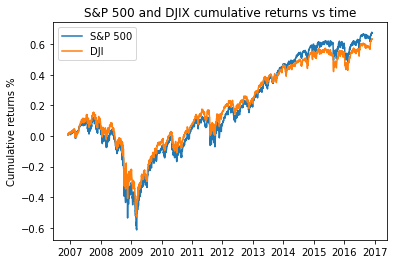

In [36]:
plt.figure()
plt.title('S&P 500 and DJIX cumulative returns vs time')
plt.ylabel('Cumulative returns %')
plt.plot(SNP500_data['cum_returns'],label = 'S&P 500')
plt.plot(DJI_data['cum_returns'],label = 'DJI')
plt.legend()
plt.show()

### Checking for class imbalance

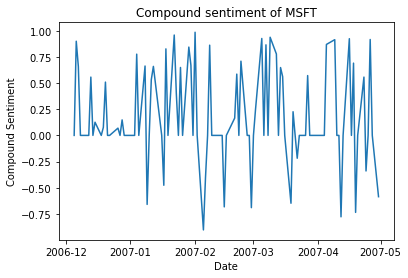

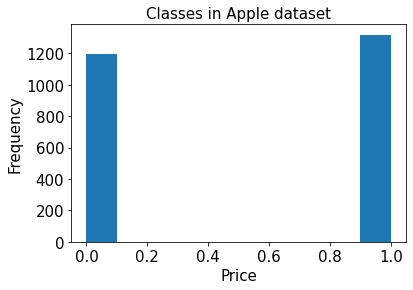

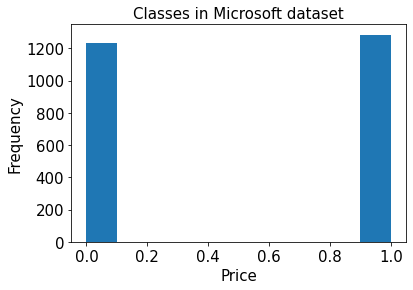

In [74]:
plt.figure(1)
plt.plot(df_weekly_Msft["compound"][1:100])
plt.xlabel("Date")
plt.ylabel("Compound Sentiment")
plt.title("Compound sentiment of MSFT")
plt.show()

df_weekly_Appl['class count'] = np.where(df_weekly_Appl['returns']>= 0, 1 , 0)
df_weekly_Msft['class count'] = np.where(df_weekly_Msft['returns']>= 0, 1 , 0)

plt.hist(df_weekly_Appl['class count'])
plt.title('Classes in Apple dataset',fontsize=15)
plt.xlabel('Price',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

plt.hist(df_weekly_Msft['class count'])
plt.title('Classes in Microsoft dataset',fontsize=15)
plt.xlabel('Price',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [38]:
def sentiment_value(df):
    analyser = SentimentIntensityAnalyzer()      
    if type(df)== str:
        result = analyser.polarity_scores(df)

    else:
        result = analyser.polarity_scores('')
    score = result['compound']
    return score

def sentiment_dataframe(df,top_k_headlines):
    
    headers = (df.columns.values)[2:top_k_headlines+2]
    matrix = np.zeros([len(df),len(headers)])
    
    for k in range(len(headers)):
        for i in range(len(df)):
            matrix[i][k] = sentiment_value(df.iloc[i][k+2])
  
    dff = pd.DataFrame()
    dff = pd.DataFrame(columns = headers)
    
    j = 0
    for col in dff.columns:
        dff.loc[:, col] = matrix[:,j]
        j += 1
    dff['Date'] = df['Date']
    
    dff['Date'] = pd.to_datetime(dff['Date'])
    dff.set_index('Date',inplace=True)
    
    return dff

In [26]:
DJI_news_compound_scores = sentiment_dataframe(DJI_news,25)
DJI_news_compound_scores

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,-0.5994,0.0000,-0.3612,-0.7089,-0.9260,0.0000,-0.2732,0.2144,-0.5719,-0.5994,...,0.0000,0.0000,0.2086,0.2023,0.0258,-0.7579,-0.6249,-0.2755,-0.8519,0.4019
2008-08-11,0.8156,-0.3182,0.4404,-0.1965,0.0000,-0.4939,-0.5106,-0.0772,-0.6688,-0.3400,...,0.0000,0.0000,-0.6597,0.0000,0.0000,-0.8020,0.0000,-0.3182,-0.1832,0.0000
2008-08-12,0.0258,0.0000,-0.7845,-0.6124,0.0000,-0.6908,-0.5994,-0.5994,0.3400,-0.7650,...,0.0000,0.0000,0.0772,-0.5994,-0.5859,0.0000,0.5267,0.3818,0.0000,0.0000
2008-08-13,-0.7184,-0.8074,-0.6369,-0.1280,-0.5106,0.0000,0.2960,0.0000,0.3612,0.0000,...,0.0000,0.0000,0.0000,-0.5423,-0.0258,-0.2960,0.4939,-0.5719,-0.4215,-0.3400
2008-08-14,0.2023,0.0000,0.6808,-0.8689,-0.6124,-0.6369,0.7177,-0.4404,-0.6808,-0.3400,...,-0.6249,0.0000,0.0000,0.0000,0.0000,-0.4404,-0.5994,0.1779,-0.6908,0.7096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-27,-0.2263,0.2732,-0.6369,-0.1027,0.6369,-0.5423,-0.7096,-0.5719,-0.5859,0.0000,...,-0.5994,0.8442,-0.5994,-0.0772,0.3182,0.1724,-0.1027,-0.6249,0.2500,0.1280
2016-06-28,0.8316,-0.4588,0.4939,0.3182,-0.7717,-0.7351,0.0000,0.2960,-0.2732,0.0000,...,0.5859,-0.6124,-0.0258,0.2732,0.2263,0.0000,0.6369,0.0000,-0.7184,-0.9349
2016-06-29,0.0000,-0.6808,0.7783,-0.7430,-0.4404,0.0000,-0.8020,0.2960,0.5719,-0.1779,...,0.5994,0.0000,-0.7430,-0.8807,-0.2263,-0.9211,-0.8402,0.2023,0.0000,0.0000


In [75]:
dataset_start = '2008-08-08'
dataset_end = '2016-07-02'

df_Msft_trim = df_weekly_Msft[(dataset_start <= df_weekly_Msft.index) & (df_weekly_Msft.index < dataset_end)]
df_Appl_trim = df_weekly_Appl[(dataset_start <= df_weekly_Appl.index) & (df_weekly_Appl.index < dataset_end)]
df_SNP500_trim = SNP500_data[(dataset_start <= SNP500_data.index) & (SNP500_data.index < dataset_end)]
df_DJI_trim = DJI_data[(dataset_start <= DJI_data.index) & (DJI_data.index < dataset_end)]

In [76]:
Dataset_final = DJI_news_compound_scores
Dataset_final['Apple compound'] = df_Appl_trim['compound']
Dataset_final['Msft compound'] = df_Msft_trim['compound']
Dataset_final['DJI returns'] = df_DJI_trim['returns']
Dataset_final['S&P 500 returns'] = df_SNP500_trim['returns']
Dataset_final['Apple returns'] = df_Appl_trim['returns']
Dataset_final['Apple Label'] = df_Appl_trim['class count']
Dataset_final['Microsoft returns'] = df_Msft_trim['returns']
Dataset_final['Microsoft Label'] = df_Msft_trim['class count']
Dataset_final.to_csv('Dataset_final.csv')
df_weekly_Appl.to_csv('Benchmark_Apple.csv')
df_weekly_Msft.to_csv('Benchmark_Msft.csv')


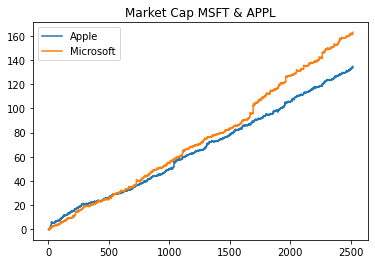

In [73]:
Appl_final['Volume'] = Appl_news['Volume']
Appl_final['Cap'] = (Appl_final['Volume']*Appl_final['Close']).pct_change()
Appl_final['Cum rets'] = Appl_final['Cap'].cumsum()

Msft_final['Volume'] = Msft_news['Volume']
Msft_final['Cap'] = (Msft_final['Volume']*Msft_final['Close']).pct_change()
Msft_final['Cum rets'] = Msft_final['Cap'].cumsum()

plt.figure()
plt.title('Market Cap MSFT & APPL')
plt.plot(Appl_final['Cum rets'],label = 'Apple')
plt.plot(Msft_final['Cum rets'], label = 'Microsoft')
plt.legend()
plt.show()